In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from functions import *
import pandas as pd
import json
import os
os.chdir(r'./')

from gliner import GLiNER
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from tqdm import tqdm

from typing import List, Dict, Any

/home/pape/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('239_annotated_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

from needed_functions import *

def replace_label(label_studio_data, old_label, new_label):
    """
    Remplace un label par un autre dans les données Label Studio.
    """
    for item in label_studio_data:
        if 'annotations' in item:
            for prediction in item['annotations']:
                for result in prediction['result']:
                    if result['type'] == 'labels':
                        labels = result['value']['labels']
                        for i, label in enumerate(labels):
                            if label == old_label:
                                labels[i] = new_label
    return label_studio_data

data = remove_text_duplicates(replace_label(filter_and_lowercase_entity_types(remove_text_duplicates(data), ["Autres"]), 'information temporelle', 'temporelle'))

print(f"Annotations uniques: {len(data)}")

Annotations uniques: 237


In [3]:
def predict(segmented_data, model_inference, classes, threshold=0.4):
    """
    Fait les prédictions sur les segments et reconstitue le texte original.
    
    Args:
        segmented_data: Données segmentées (format de segment_text_by_tokens_optimized)
        model_inference: Modèle pour faire les prédictions
        classes: Liste des classes à prédire
        threshold: Seuil de confiance
    
    Returns:
        list: Données Label Studio avec prédictions reconstituées
    """
    
    # 1. Faire les prédictions sur chaque segment
    segments_with_predictions = []
    
    for segment in segmented_data:
        # Prédictions sur le texte du segment
        segment_text = segment['text']
        predictions = model_inference.predict_entities(segment_text, classes, threshold=threshold)
        
        # Convertir les prédictions au format entities du segment
        segment_entities = []
        for pred in predictions:
            # Vérifier que la prédiction est valide dans le segment
            if (pred['start'] >= 0 and 
                pred['end'] <= len(segment_text) and 
                pred['start'] < pred['end']):
                
                # Extraire le texte réel pour éviter les erreurs
                actual_text = segment_text[pred['start']:pred['end']]
                
                segment_entities.append({
                    'start': pred['start'],
                    'end': pred['end'],
                    'text': actual_text,  # Utiliser le texte extrait
                    'label': pred['label'].lower()
                })
        
        # Créer nouveau segment avec prédictions
        segment_with_pred = segment.copy()
        segment_with_pred['entities'] = segment_entities
        segments_with_predictions.append(segment_with_pred)
    
    # 2. Reconstituer en utilisant la fonction existante
    reconstructed_data = reconstruct_from_segments(segments_with_predictions)
    
    # 3. Post-traitement pour nettoyer les prédictions bizarres
    cleaned_data = []
    for item in reconstructed_data:
        cleaned_item = item.copy()
        
        if 'annotations' in item and item['annotations']:
            cleaned_annotations = []
            
            for annotation in item['annotations']:
                cleaned_results = []
                
                for result in annotation.get('result', []):
                    if result.get('type') == 'labels':
                        value = result['value']
                        text = value['text']
                        
                        # Filtrer les textes bizarres
                        if (len(text.strip()) > 0 and 
                            not text.startswith(' ') and 
                            not text.endswith(' ') and
                            len(text) > 1):  # Au moins 2 caractères
                            cleaned_results.append(result)
                
                if cleaned_results:
                    cleaned_annotation = annotation.copy()
                    cleaned_annotation['result'] = cleaned_results
                    cleaned_annotations.append(cleaned_annotation)
            
            cleaned_item['annotations'] = cleaned_annotations
        
        cleaned_data.append(cleaned_item)
    
    return cleaned_data

def eval_ner(gold_data: List[Dict[str, Any]], pred_data: List[Dict[str, Any]], entity_labels: List[str]):
    """
    Évalue les prédictions NER avec support fixe basé sur gold_data uniquement.
    Retourne un DataFrame des métriques globales et une liste des f1 par document.
    Si un article gold est absent des prédictions, on le pénalise uniquement
    s’il contient une entité de type 'Magasin_producteurs'.
    """

    # Indexation par ID
    gold_dict = {str(item["id"]): item for item in gold_data}
    pred_dict = {str(item["id"]): item for item in pred_data}

    common_ids = set(gold_dict.keys()) & set(pred_dict.keys())

    y_true_labels = []
    y_pred_labels = []
    gold_counts = {lbl: 0 for lbl in entity_labels}
    f1_by_doc = {}

    # === Gestion des articles manquants ===
    missing_ids = set(gold_dict.keys()) - set(pred_dict.keys())
    for doc_id in missing_ids:
        gold_item = gold_dict[doc_id]
        gold_entities = set()
        for ann in gold_item.get('annotations', []):
            for res in ann.get('result', []):
                if res.get('type') == 'labels':
                    lbl = res['value']['labels'][0]
                    if lbl in entity_labels:
                        gold_entities.add((res['value']['text'].strip(), lbl))
                        gold_counts[lbl] += 1  

        # Vérifie s'il faut pénaliser (présence d'une entité "Magasin_producteurs")
        penalize = any(lbl == "magasin de producteurs" for _, lbl in gold_entities)

        if penalize:
            for ent in gold_entities:
                y_true_labels.append(ent[1])
                y_pred_labels.append("NONE")

    # === Comparaison sur les IDs communs ===
    for doc_id in common_ids:
        gold_item = gold_dict[doc_id]
        pred_item = pred_dict[doc_id]

        # Gold
        gold_entities = set()
        for ann in gold_item.get('annotations', []):
            for res in ann.get('result', []):
                if res.get('type') == 'labels':
                    lbl = res['value']['labels'][0]
                    if lbl in entity_labels:
                        gold_entities.add((res['value']['text'].strip(), lbl))
                        gold_counts[lbl] += 1  

        # Pred
        pred_entities = set()
        for ann in pred_item.get('annotations', []):
            for res in ann.get('result', []):
                if res.get('type') == 'labels':
                    lbl = res['value']['labels'][0]
                    if lbl in entity_labels:
                        pred_entities.add((res['value']['text'].strip(), lbl))

        # Y pour ce document
        y_true_doc = []
        y_pred_doc = []

        # TP
        for ent in gold_entities & pred_entities:
            y_true_labels.append(ent[1])
            y_pred_labels.append(ent[1])
            y_true_doc.append(ent[1])
            y_pred_doc.append(ent[1])

        # FN
        for ent in gold_entities - pred_entities:
            y_true_labels.append(ent[1])
            y_pred_labels.append("NONE")
            y_true_doc.append(ent[1])
            y_pred_doc.append("NONE")

        # FP
        for ent in pred_entities - gold_entities:
            y_true_labels.append("NONE")
            y_pred_labels.append(ent[1])
            y_true_doc.append("NONE")
            y_pred_doc.append(ent[1])

        # calcul F1 micro pour ce document
        if y_true_doc:  # éviter division par zéro
            f1_doc = f1_score(y_true_doc, y_pred_doc, labels=entity_labels, average="micro", zero_division=0)
        else:
            f1_doc = 0.0
        f1_by_doc[doc_id] = round(f1_doc, 4)

    # Rapport global
    report = classification_report(
        y_true_labels,
        y_pred_labels,
        labels=entity_labels,
        target_names=entity_labels,
        output_dict=True,
        zero_division=0
    )

    # Calcul global
    total_support = sum(gold_counts.values())
    micro_p = precision_score(y_true_labels, y_pred_labels, labels=entity_labels, average="micro", zero_division=0)
    micro_r = recall_score(y_true_labels, y_pred_labels, labels=entity_labels, average="micro", zero_division=0)
    micro_f1 = f1_score(y_true_labels, y_pred_labels, labels=entity_labels, average="micro", zero_division=0)

    macro_p = sum(report[lbl]["precision"] for lbl in entity_labels) / len(entity_labels)
    macro_r = sum(report[lbl]["recall"] for lbl in entity_labels) / len(entity_labels)
    macro_f1 = sum(report[lbl]["f1-score"] for lbl in entity_labels) / len(entity_labels)

    weighted_p = sum(report[lbl]["precision"] * gold_counts[lbl] for lbl in entity_labels) / total_support
    weighted_r = sum(report[lbl]["recall"] * gold_counts[lbl] for lbl in entity_labels) / total_support
    weighted_f1 = sum(report[lbl]["f1-score"] * gold_counts[lbl] for lbl in entity_labels) / total_support

    final_report = {}
    for lbl in entity_labels:
        final_report[lbl] = {
            "precision": round(report[lbl]["precision"], 4),
            "recall": round(report[lbl]["recall"], 4),
            "f1-score": round(report[lbl]["f1-score"], 4),
            "support": int(gold_counts[lbl])
        }

    final_report["micro avg"] = {
        "precision": round(micro_p, 4),
        "recall": round(micro_r, 4),
        "f1-score": round(micro_f1, 4),
        "support": int(total_support)
    }
    final_report["macro avg"] = {
        "precision": round(macro_p, 4),
        "recall": round(macro_r, 4),
        "f1-score": round(macro_f1, 4),
        "support": int(total_support)
    }
    final_report["weighted avg"] = {
        "precision": round(weighted_p, 4),
        "recall": round(weighted_r, 4),
        "f1-score": round(weighted_f1, 4),
        "support": int(total_support)
    }

    df_report = pd.DataFrame(final_report).T.reset_index().rename(columns={"index": "label"})
    scores = {"report": df_report, "f1_by_doc": f1_by_doc}
    return scores

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")


In [4]:
from sklearn.model_selection import train_test_split

# _, for_test_2= train_test_split(
#     data, 
#     test_size=0.2,
#     random_state=42,
#     shuffle=True
# )

for_test_2 = data
print(f"Test data : {len(for_test_2)}")

Test data : 237


In [35]:
from DynamicSegmentation import ThematicSegmenter
from SemanticQueryV1 import SemanticSearchEngine, SearchConfig

segmenter = ThematicSegmenter(window_size=2)
config = SearchConfig(threshold=0.1, batch_size=16, max_sequence_length=512)
search_engine = SemanticSearchEngine("paraphrase-multilingual-MiniLM-L12-v2", config)
thematic_seg =  split_thematic_segment_labelstudio(for_test_2, segmenter)

2025-09-30 12:41:05,329 - INFO - Use pytorch device_name: cuda
2025-09-30 12:41:05,331 - INFO - Load pretrained SentenceTransformer: paraphrase-multilingual-MiniLM-L12-v2
2025-09-30 12:41:08,278 - INFO - Load pretrained SentenceTransformer: paraphrase-multilingual-MiniLM-L12-v2
Batches: 100%|██████████| 1/1 [00:00<00:00, 99.05it/s]


In [36]:
from gliner import GLiNER

models = ["urchade/gliner_multi-v2.1", "numind/NuNerZero_span", "gliner_last_model", "nuner_last_model","best-gliner_model-v1","best-nuner_model-v1","gliner_only","nuner_only"]

device="cuda"
model = GLiNER.from_pretrained(models[7], max_length=512)
model.to(device)

labels = ['temporelle', 'producteur/artisan', 'organisation', 'point de vente', 
            'réseau de magasins', 'nombre de magasins', 'nombre de producteurs', 
            'lieu', 'produit', 'magasin de producteurs', 'déclencheur']

config.json not found in /home/pape/myenv/nuner_only
2025-09-30 12:41:17,789 - WARNING - config.json not found in /home/pape/myenv/nuner_only


In [37]:
len(data), len(thematic_seg)

(237, 877)

In [38]:
# 2. THEMATIC + PASSAGE RETRIEVER
retrieved = search_engine.search(
    query="Le magasin de producteurs est un point de vente collectif qui regroupe plusieurs agriculteurs qui ont pour objectif de valoriser leur exploitation et leur production fermière",
    label_studio_data=thematic_seg
    )

Calcul des embeddings: 100%|██████████| 55/55 [00:01<00:00, 46.17it/s]


In [39]:
len(retrieved)

805

In [40]:
sliding_window = segment_text_by_tokens(for_test_2, tokenizer, max_tokens = 500, overlap_tokens=50)
chunking = segment_text_by_tokens(for_test_2, tokenizer, max_tokens = 500, overlap_tokens=0)

print("🔄 Étape 2: Prédiction et reconstitution...")
# sliding window
predicted_sw = predict(sliding_window, model, labels, threshold=0.4)

# Chunking
predicted_ch = predict(chunking, model, labels, threshold=0.4)

# Thematic
predicted_th = predict(thematic_seg, model, labels, threshold=0.4)

# Thematic + retriever
predicted_tr = predict(retrieved, model, labels, threshold=0.4)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


🔄 Étape 2: Prédiction et reconstitution...


/home/pape/.local/lib/python3.10/site-packages/gliner/data_processing/processor.py:296: UserWarning: Sentence of length 534 has been truncated to 512
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")


In [41]:
gold_ids = {str(item.get("id") or item["data"].get("id")) for item in for_test_2}
pred_ids = {str(item.get("id") or item["data"].get("id")) for item in predicted_tr}

missing_ids = gold_ids - pred_ids

print(f"Articles manquants : {missing_ids}")

Articles manquants : {'17418'}


In [42]:
scores_th = eval_ner(for_test_2, predicted_th, labels)
scores_sw = eval_ner(for_test_2, predicted_sw, labels)
scores_ch = eval_ner(for_test_2, predicted_ch, labels)
scores_tr = eval_ner(for_test_2, predicted_tr, labels)

In [43]:
print("************Thématique************")
print(scores_th["report"].loc[11])
print("************Thématique + retrieval************")
print(scores_tr["report"].loc[11])
print("************Sliding window************")
print(scores_sw["report"].loc[11]) 
print("************Chunking************")
print(scores_ch["report"].loc[11])

************Thématique************
label        micro avg
precision       0.7567
recall          0.8697
f1-score        0.8093
support         6569.0
Name: 11, dtype: object
************Thématique + retrieval************
label        micro avg
precision       0.7665
recall          0.8385
f1-score        0.8009
support         6569.0
Name: 11, dtype: object
************Sliding window************
label        micro avg
precision       0.7726
recall          0.8733
f1-score        0.8199
support         6569.0
Name: 11, dtype: object
************Chunking************
label        micro avg
precision       0.6163
recall          0.6249
f1-score        0.6206
support         6569.0
Name: 11, dtype: object


In [21]:
scores_sw["report"]

,label,precision,recall,f1-score,support
0,temporelle,0.1950,0.0473,0.0761,682.0
1,producteur/artisan,0.6033,0.5211,0.5592,862.0
2,organisation,0.4035,0.1296,0.1962,396.0
3,point de vente,0.0730,0.0616,0.0668,294.0
4,réseau de magasins,0.1607,0.3600,0.2222,63.0
5,nombre de magasins,0.6250,0.3333,0.4348,51.0
6,nombre de producteurs,0.5521,0.5464,0.5492,214.0
7,lieu,0.7358,0.1554,0.2566,1347.0
8,produit,0.8421,0.3995,0.5419,1578.0
9,magasin de producteurs,0.4836,0.3533,0.4083,503.0


In [15]:
len(scores_th['f1_by_doc']), len(scores_sw['f1_by_doc']), len(scores_ch['f1_by_doc']), len(scores_tr['f1_by_doc'])

(237, 237, 237, 236)

=== Test de normalité (Shapiro-Wilk) ===
Thematic: p = 0.58495 (normale)
Thematic + Retrieval: p = 0.38938 (normale)
Sliding Window: p = 0.03557 (non normale)
Chunking: p = 0.00000 (non normale)

=== Test de variance (Levene) ===
Thematic vs Thematic + Retrieval: p = 0.74584 (variances égales)
Thematic vs Sliding Window: p = 0.22973 (variances égales)
Thematic vs Chunking: p = 0.03884 (variances inégales)
Thematic + Retrieval vs Sliding Window: p = 0.38069 (variances égales)
Thematic + Retrieval vs Chunking: p = 0.08071 (variances égales)
Sliding Window vs Chunking: p = 0.37635 (variances égales)

=== Tests statistiques (t-test / Wilcoxon / Mann-Whitney) ===
Thematic vs Thematic + Retrieval: t-test non pairé → p = 0.68037
Thematic vs Sliding Window: Mann-Whitney (non pairé) → p = 0.00879
Thematic vs Chunking: Mann-Whitney (non pairé) → p = 0.00000
Thematic + Retrieval vs Sliding Window: Mann-Whitney (non pairé) → p = 0.02859
Thematic + Retrieval vs Chunking: Mann-Whitney (non pairé) → 

/tmp/ipykernel_326392/198846035.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x="Segmentation types", y="F1-score", palette="Set2")


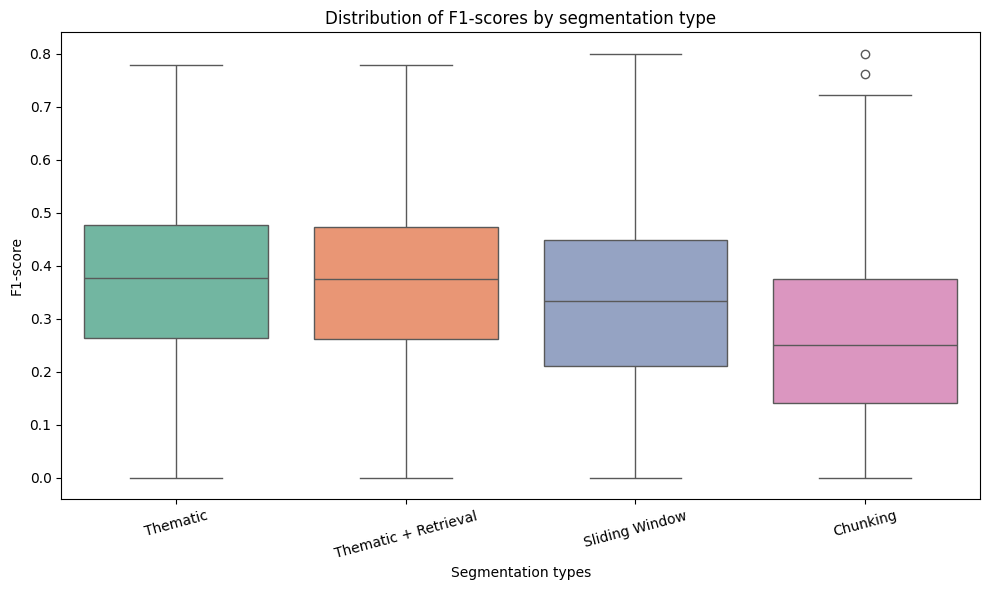

In [22]:
from scipy.stats import ttest_ind, ttest_rel, wilcoxon, shapiro, levene, mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

f1_data = {
    "Thematic": list(scores_th['f1_by_doc'].values()),
    "Thematic + Retrieval": list(scores_tr['f1_by_doc'].values()),
    "Sliding Window": list(scores_sw['f1_by_doc'].values()),
    "Chunking": list(scores_ch['f1_by_doc'].values()),
}

# Vérification normalité
print("=== Test de normalité (Shapiro-Wilk) ===")
normality_results = {}
for name, scores in f1_data.items():
    stat, p = shapiro(scores)
    normality_results[name] = (p > 0.05)
    print(f"{name}: p = {p:.5f} {'(normale)' if p > 0.05 else '(non normale)'}")

# Vérification des variances
print("\n=== Test de variance (Levene) ===")
comparisons = [
    ("Thematic", "Thematic + Retrieval"),
    ("Thematic", "Sliding Window"),
    ("Thematic", "Chunking"),
    ("Thematic + Retrieval", "Sliding Window"),
    ("Thematic + Retrieval", "Chunking"),
    ("Sliding Window", "Chunking"),  # ajouté ici aussi
]

for name1, name2 in comparisons:
    stat, p = levene(f1_data[name1], f1_data[name2])
    print(f"{name1} vs {name2}: p = {p:.5f} {'(variances égales)' if p > 0.05 else '(variances inégales)'}")

# Application du test statistique approprié
print("\n=== Tests statistiques (t-test / Wilcoxon / Mann-Whitney) ===")
for name1, name2 in comparisons:
    data1, data2 = f1_data[name1], f1_data[name2]
    p_norm1, p_norm2 = normality_results[name1], normality_results[name2]

    # Cas particulier : Sliding Window vs Chunking → données pairées
    if name1 == "Sliding Window" and name2 == "Chunking":
        if p_norm1 and p_norm2:
            stat, p = ttest_rel(data1, data2)
            test_name = "t-test pairé"
        else:
            stat, p = wilcoxon(data1, data2)
            test_name = "Wilcoxon pairé"
    else:
        if p_norm1 and p_norm2:
            stat, p = ttest_ind(data1, data2, equal_var=False)
            test_name = "t-test non pairé"
        else:
            stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
            test_name = "Mann-Whitney (non pairé)"

    print(f"{name1} vs {name2}: {test_name} → p = {p:.5f}")

# Boxplot
all_data = []
for strategy, scores in f1_data.items():
    for score in scores:
        all_data.append({"Segmentation types": strategy, "F1-score": score})
df_plot = pd.DataFrame(all_data)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_plot, x="Segmentation types", y="F1-score", palette="Set2")
plt.title("Distribution of F1-scores by segmentation type")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
